# Test on handling video file in Python
## Use labeled video to determine time on screen of main characters

In [1]:
import math
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from keras.preprocessing import image
from keras.utils import np_utils
from skimage.transform import resize

from keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Use 1st video file to train model, sample 1 frame per second.

In [2]:
inputFolder = "./SampleVideo/"
outputFolder = "./OutputFrames/"

In [3]:
videoFile = inputFolder + "Tom and Jerry.mp4"
count = 0
# Create handle for video
capture = cv2.VideoCapture(videoFile)
frameRate = capture.get(5)

print("Frame Rate:", frameRate)
# Iterate through video and get individual images

while(capture.isOpened()):
    frameId = capture.get(1)   # frame number
    ret, frame = capture.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):    # extracting 1 frame per second
        filename = f'{outputFolder}frame{count:04d}.jpg'
        count += 1
#        print("Save file: ", filename)
        cv2.imwrite(filename, frame)
capture.release()
print(count,"frames extracted.")

Frame Rate: 30.0
298 frames extracted.


# Labels for images already in CSV file
## Classes as follow:
0 - neither JERRY nor TOM

1 - for JERRY

2 - for TOM

In [4]:
data = pd.read_csv(inputFolder+'mapping.csv')
data.head()

,Image_ID,Class
0,frame0000.jpg,1
1,frame0001.jpg,1
2,frame0002.jpg,2
3,frame0003.jpg,2
4,frame0004.jpg,2


# Check visualizing a frame

Class:  2


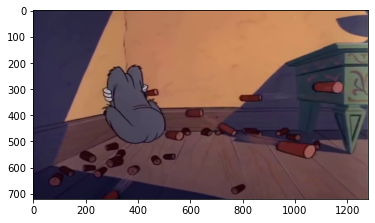

In [14]:
# visualize an image frame
frameNumber = 280
filename = outputFolder + f'frame{frameNumber:04d}.jpg'
img = plt.imread(filename)
print('Class: ', data.Class[frameNumber])
plt.imshow(img)

In [9]:
#  Create array that contains all the frames
X = []
for i in range(count):
    img_name = f'frame{i:04d}.jpg'
    img = plt.imread(outputFolder+img_name)
    X.append(img)
X = np.array(X)

In [10]:
y = data.Class
# one hot encoding
dummy_y = np_utils.to_categorical(y)

In [17]:
# resize all the images to 224x224x3 as required by vgg16
image = []
for i in range(0, X.shape[0]):
    a = resize(X[i], preserve_range=True, output_shape=(224,224)).astype(int)
    image.append(a)
X = np.array(image)

In [18]:
# required step
# from keras.applications.vgg16 import preprocess_input
X = preprocess_input(X, mode='tf')

In [19]:
# split train and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(X, dummy_y, test_size=0.3, random_state=10)

In [20]:
X_train.shape

(208, 224, 224, 3)

In [21]:
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout

In [22]:
# use pretrained model VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))   #top layer not included

In [23]:
X_train = base_model.predict(X_train)
X_validation = base_model.predict(X_validation)


In [24]:
X_train.shape, X_validation.shape

((208, 7, 7, 512), (90, 7, 7, 512))

In [26]:
X_train.shape[1]

7

In [28]:
# Neural network requires a 1-D shape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]*X_train.shape[3])
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1]*X_validation.shape[2]*X_validation.shape[3])

In [29]:
# Center the data
train_X = X_train / X_train.max()
validation_X = X_validation / X_validation.max()

# Build and train the model

In [34]:
# output layer has 3 neurons as we have 3 classes to predict.
model = Sequential()
model.add(InputLayer((7*7*512,)))
model.add(Dense(units=1024, activation='sigmoid'))
#model.add(Dropout(0.5))
model.add(Dense(units=512, activation='sigmoid'))
model.add(Dense(units=256, activation='sigmoid'))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dense_14 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_15 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 771       
Total params: 26,348,035
Trainable params: 26,348,035
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [36]:
# add weights as classes are unbalanced
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
class_weights = compute_class_weight('balanced', np.unique(data.Class), data.Class)

C:\Users\jvo1\.conda\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2], y=0      1
1      1
2      2
3      2
4      2
      ..
293    0
294    0
295    0
296    0
297    0
Name: Class, Length: 298, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [39]:
from keras.callbacks import ModelCheckpoint
filepath = "best_model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [40]:
model.fit(train_X, y_train, epochs=100, validation_data=(X_validation, y_validation), class_weight=class_weights, callbacks=callbacks_list)

Train on 208 samples, validate on 90 samples
Epoch 1/100
208/208 [==============================] - 2s 9ms/step - loss: 1.3535 - accuracy: 0.3798 - val_loss: 1.1544 - val_accuracy: 0.5889

Epoch 00001: val_loss improved from inf to 1.15440, saving model to best_model.hdf5
Epoch 2/100
208/208 [==============================] - 2s 8ms/step - loss: 1.0789 - accuracy: 0.4471 - val_loss: 1.0052 - val_accuracy: 0.4556

Epoch 00002: val_loss improved from 1.15440 to 1.00516, saving model to best_model.hdf5
Epoch 3/100
208/208 [==============================] - 2s 8ms/step - loss: 1.0313 - accuracy: 0.4471 - val_loss: 0.8122 - val_accuracy: 0.6000

Epoch 00003: val_loss improved from 1.00516 to 0.81220, saving model to best_model.hdf5
Epoch 4/100
208/208 [==============================] - 2s 8ms/step - loss: 0.9092 - accuracy: 0.5769 - val_loss: 0.6575 - val_accuracy: 0.7667

Epoch 00004: val_loss improved from 0.81220 to 0.65751, saving model to best_model.hdf5
Epoch 5/100
208/208 [==========


Epoch 00040: val_loss did not improve from 0.11484
Epoch 41/100
208/208 [==============================] - 2s 8ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.1592 - val_accuracy: 0.9667

Epoch 00041: val_loss did not improve from 0.11484
Epoch 42/100
208/208 [==============================] - 2s 8ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.1599 - val_accuracy: 0.9667

Epoch 00042: val_loss did not improve from 0.11484
Epoch 43/100
208/208 [==============================] - 2s 8ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.1600 - val_accuracy: 0.9667

Epoch 00043: val_loss did not improve from 0.11484
Epoch 44/100
208/208 [==============================] - 2s 8ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.1605 - val_accuracy: 0.9667

Epoch 00044: val_loss did not improve from 0.11484
Epoch 45/100
208/208 [==============================] - 2s 8ms/step - loss: 9.8510e-04 - accuracy: 1.0000 - val_loss: 0.1614 - val_accuracy: 0.9667

Epoch 00045: va

208/208 [==============================] - 2s 8ms/step - loss: 4.2336e-04 - accuracy: 1.0000 - val_loss: 0.1862 - val_accuracy: 0.9556

Epoch 00082: val_loss did not improve from 0.11484
Epoch 83/100
208/208 [==============================] - 2s 8ms/step - loss: 4.1668e-04 - accuracy: 1.0000 - val_loss: 0.1864 - val_accuracy: 0.9556

Epoch 00083: val_loss did not improve from 0.11484
Epoch 84/100
208/208 [==============================] - 2s 8ms/step - loss: 4.0938e-04 - accuracy: 1.0000 - val_loss: 0.1875 - val_accuracy: 0.9556

Epoch 00084: val_loss did not improve from 0.11484
Epoch 85/100
208/208 [==============================] - 2s 8ms/step - loss: 4.0249e-04 - accuracy: 1.0000 - val_loss: 0.1883 - val_accuracy: 0.9556

Epoch 00085: val_loss did not improve from 0.11484
Epoch 86/100
208/208 [==============================] - 2s 8ms/step - loss: 3.9620e-04 - accuracy: 1.0000 - val_loss: 0.1881 - val_accuracy: 0.9556

Epoch 00086: val_loss did not improve from 0.11484
Epoch 87/100


In [41]:
model.load_weights("best_model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Now apply model to another video

In [42]:
videoFile = inputFolder + "Tom and Jerry 3.mp4"
outputFolder =  "./OutputFramesTest/"
count = 0
# Create handle for video
capture = cv2.VideoCapture(videoFile)
frameRate = capture.get(5)

print("Frame Rate:", frameRate)
# Iterate through video and get individual images
while(capture.isOpened()):
    frameId = capture.get(1)   # frame number
    ret, frame = capture.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):    # extracting 1 frame per second
        filename = f'{outputFolder}frame{count:04d}.jpg'
#        print(ret, frameId)
        count += 1
#        print("Save file: ", filename)
        cv2.imwrite(filename, frame)
capture.release()
print(count,"frames extracted.")

Frame Rate: 29.97002997002997
186 frames extracted.


In [43]:
test_image = []
for i in range(count):
    img_name = f'{outputFolder}frame{i:04d}.jpg'
    img = plt.imread(''+img_name)
    test_image.append(img)
test_img = np.array(test_image)

In [44]:
test_image = []
for i in range(0,test_img.shape[0]):
    a = resize(test_img[i], preserve_range=True, output_shape=(224,224)).astype(int)
    test_image.append(a)
test_img = np.array(test_image)

In [45]:
# preprocess the images
test_img = preprocess_input(test_img, mode='tf')
test_img = base_model.predict(test_img)
test_img = test_img.reshape(186, 7*7*512)
test_img = test_img / test_img.max()

In [46]:
# predict using model trained with previous video
test_prediction = model.predict_classes(test_img)

In [47]:
print('Screen time for Jerry is ', test_prediction[test_prediction==1].shape[0],' seconds')
print('Screen time for Tom is ', test_prediction[test_prediction==2].shape[0],' seconds')

Screen time for Jerry is  11  seconds
Screen time for Tom is  115  seconds


In [ ]:
#scores = model.evaluate(test_img, te